## Pascal VOC dataset encoding with tfrecord 
### Goals
* Implementing FCN (Fully convolutional networks) for semantic segmentation with TF-slim
* Learn how to reuse an existing model with modifications.

### Contents
* Create your dataset 
 * Download PASCAL VOC 2012 dataset (2Gb)
 http://host.robots.ox.ac.uk/pascal/VOC/voc2012/#devkit
 * Create .tfrecord files for training and validation sets

In [1]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Pascal VOC Dataset
path_pascal = "/home/koosy/git/ralss17/data/VOC2012"

# Get a list of image/annotation pairs
images_folder = os.path.join(path_pascal, 'JPEGImages')
annot_folder = os.path.join(path_pascal, 'SegmentationClass')

# get_pascal_segmentation_images_lists_txts
segmentation_folder = os.path.join(path_pascal, 'ImageSets/Segmentation')
train_list = os.path.join(segmentation_folder, 'train.txt')
valid_list = os.path.join(segmentation_folder, 'val.txt')

def readlines_with_strip(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()

    # Clean filenames from whitespaces and newline symbols
    clean_lines = map(lambda x: x.strip(), lines)
    return clean_lines

train_image_names = readlines_with_strip(train_list)
valid_image_names = readlines_with_strip(valid_list)

train_images_full_names = [images_folder + '/' + x + '.jpg' for x in train_image_names]
train_annot_full_names = [annot_folder + '/' + x + '.png' for x in train_image_names]
train_filename_pairs = zip(train_images_full_names, train_annot_full_names)

valid_images_full_names = [images_folder + '/' + x + '.jpg' for x in valid_image_names]
valid_annot_full_names = [annot_folder + '/' + x + '.png' for x in valid_image_names]
valid_filename_pairs = zip(valid_images_full_names, valid_annot_full_names)

In [3]:
def write_tfrecords(filename_pairs, tfrecords_filename):
    writer = tf.python_io.TFRecordWriter(tfrecords_filename)
    for img_path, annotation_path in filename_pairs:
        
        # Load the image
        img = np.array(Image.open(img_path))
        annotation = np.array(Image.open(annotation_path))
        img_raw = img.tostring()
        annotation_raw = annotation.tostring()
        
        height = img.shape[0]
        width = img.shape[1]

        
        # Create a feature
        feature={
            'height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
            'width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
            'image_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw])),
            'mask_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[annotation_raw]))
        }
        
        # Create an example protocol buffer
        example = tf.train.Example(features=tf.train.Features(feature=feature))

        # Serialize to string and write on the file
        writer.write(example.SerializeToString())
    writer.close()

In [4]:
# Save .tfrecord files
file_train = "data/pascal_train.tfrecords"
file_val = "data/pascal_val.tfrecords"

write_tfrecords(train_filename_pairs, file_train)
write_tfrecords(valid_filename_pairs, file_val)

In [6]:
# Read .tfrecord file
reconstructed_images = []
record_iterator = tf.python_io.tf_record_iterator(path=file_train)

for string_record in record_iterator:    
    example = tf.train.Example()
    example.ParseFromString(string_record)
    
    height = int(example.features.feature['height']
                                 .int64_list
                                 .value[0])
    
    width = int(example.features.feature['width']
                                .int64_list
                                .value[0])
    
    img_string = (example.features.feature['image_raw']
                                  .bytes_list
                                  .value[0])
    
    annotation_string = (example.features.feature['mask_raw']
                                .bytes_list
                                .value[0])
    img_1d = np.fromstring(img_string, dtype=np.uint8)
    reconstructed_img = img_1d.reshape((height, width, -1))
    
    annotation_1d = np.fromstring(annotation_string, dtype=np.uint8)
    
    # Annotations don't have depth (3rd dimension)
    reconstructed_annotation = annotation_1d.reshape((height, width))    
    reconstructed_images.append((reconstructed_img, reconstructed_annotation))

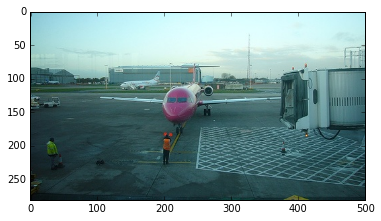

In [18]:
img = reconstructed_images[0][0]
plt.imshow(img)

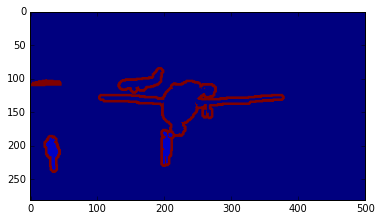

In [19]:
annot = reconstructed_images[0][1]
plt.imshow(annot)